In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
vishakhdapat_sms_spam_detection_dataset_path = kagglehub.dataset_download('vishakhdapat/sms-spam-detection-dataset')

print('Data source import complete.')


100%|██████████| 207k/207k [00:00<00:00, 59.8MB/s]

Extracting files...
Data source import complete.


In [2]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.4 MB/s eta 0:00:00


In [3]:
pip install tensorflow==2.10.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.10.1 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.10.1


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import contractions
import emoji
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense

In [10]:
df = pd.read_csv(vishakhdapat_sms_spam_detection_dataset_path + "/spam_sms.csv", encoding = 'latin1')

In [11]:
print(df.shape)
df.head()

(5572, 2)


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
# Check is there any null values?
df.isnull().sum()

,0
v1,0
v2,0


In [13]:
# Check is there any duplicate values
df.duplicated().sum()

np.int64(403)

In [14]:
# Drop Duplicate values
df.drop_duplicates(inplace = True)

In [15]:
# Check the shape of df
df.shape

(5169, 2)

In [16]:
# Rename Cloumn Header
df.rename(columns = {'v1':'label', 'v2':'Text'}, inplace = True)
df.head()

,label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
# Define preprocess function to clean the text
nlp = spacy.load("en_core_web_lg")

def preprocess(text):
    text = re.sub(r'[^a-zA-Z0-9\']', ' ', text)
    text = re.sub(r' +', ' ', text)
    text = emoji.demojize(text, delimiters = ("", " "))
    text = contractions.fix(text).lower()
    doc = nlp(text)
    filtered_text = ""
    for sent in doc.sents:
        filtered_tokens = [token.lemma_ for token in sent if not token.is_stop and not token.is_punct]
        filtered_sentence = ' '.join(filtered_tokens)
        filtered_text += filtered_sentence + ' '
    filtered_text = filtered_text.strip().lower()
    return filtered_text

In [20]:
# Apply function to Text column
df['filtered_Text'] = df['Text'].apply(preprocess)

In [21]:
# Convert label to numerical
df['label_num'] = df['label'].map({
    'ham':0,
    'spam':1
})

In [22]:
df.head()

,label,Text,filtered_Text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,dun early hor c,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf live,0


In [23]:
# Split the data into training and testing set

X = df['filtered_Text']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = df['label_num'])

In [24]:
# Tokenization
tokenizer = Tokenizer(num_words = 5000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [26]:
# Convert text sequences into integer sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [27]:
# Padding
max_len = 100   # OR max_length = max(len(x) for x in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen = max_len, padding = 'post')
X_test_padded = pad_sequences(X_test_seq, maxlen = max_len, padding = 'post')

In [28]:
model = Sequential()
model.add(Embedding(10000, 128, input_length = 100))
model.add(Conv1D(128, 5, activation = 'relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, min_lr = 0.0001)
model_checkpoint = ModelCheckpoint("my_checkpoints.keras", save_best_only = True, monitor = 'val_loss', mode = 'min')

In [32]:
# Compute class weight
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes = np.unique(df['label_num']), y = df['label_num'])


# Convert class weights to a dictionary to pass to model.fit
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: np.float64(0.5722984942426926), 1: np.float64(3.9578866768759573)}


In [33]:
history = model.fit(X_train_padded, y_train, epochs = 15, validation_data = (X_test_padded, y_test),
                   callbacks = [reduce_lr, model_checkpoint], class_weight = class_weight_dict)

Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - accuracy: 0.7109 - loss: 0.4202 - val_accuracy: 0.9836 - val_loss: 0.0630 - learning_rate: 0.0010
Epoch 2/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9925 - loss: 0.0490 - val_accuracy: 0.9275 - val_loss: 0.2327 - learning_rate: 0.0010
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9950 - loss: 0.0431 - val_accuracy: 0.9797 - val_loss: 0.0622 - learning_rate: 0.0010
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9982 - loss: 0.0130 - val_accuracy: 0.9807 - val_loss: 0.0638 - learning_rate: 0.0010
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9998 - loss: 0.0032 - val_accuracy: 0.9816 - val_loss: 0.0774 - learning_rate: 0.0010
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 1.0000 - loss: 5.7666e-04 - val_accuracy: 0.9816 - val_loss: 0.0724 - learning_rate: 2.0000e-04
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 1.0

In [34]:
test_loss, test_acc = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {test_acc*100:.2f}%')

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9864 - loss: 0.0612
Test Accuracy: 98.16%


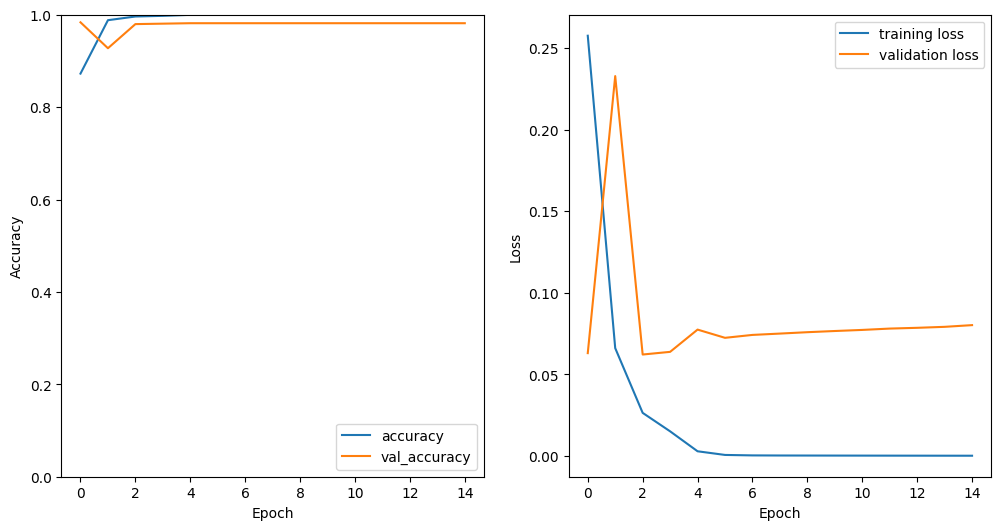

In [35]:
# Plot Epoch vs Accuracy
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(history.history['accuracy'], label = 'accuracy')
sns.lineplot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

# Plot Epoch vs Loss
plt.subplot(1, 2, 2)
sns.lineplot(history.history['loss'], label = 'training loss')
sns.lineplot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.show()
plt.show()

In [36]:
# Test the model on new sms

new_sms = "Congratulations! You've won a free ticket to Bahamas. Text 'WON' to 44255 to claim now!"
preprocessed_sms = preprocess(new_sms)
print("Preprocessed SMS:", preprocessed_sms)
# Convert the text to a sequence of integers
sms_seq = tokenizer.texts_to_sequences([preprocessed_sms])

# Pad the sequence
sms_padded = pad_sequences(sms_seq, maxlen=max_len, padding='post')
prediction = model.predict(sms_padded)
if prediction[0][0] > 0.5:
    print("The SMS is predicted to be: Spam")
else:
    print("The SMS is predicted to be: Ham")

Preprocessed SMS: congratulation win free ticket bahamas text win 44255 claim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
The SMS is predicted to be: Spam


In [37]:
new_sms = "Hey, are we still meeting for coffee this afternoon?"
preprocessed_sms = preprocess(new_sms)
print("Preprocessed SMS:", preprocessed_sms)
# Convert the text to a sequence of integers
sms_seq = tokenizer.texts_to_sequences([preprocessed_sms])

# Pad the sequence
sms_padded = pad_sequences(sms_seq, maxlen=max_len, padding='post')
prediction = model.predict(sms_padded)
if prediction[0][0] > 0.5:
    print("The SMS is predicted to be: Spam")
else:
    print("The SMS is predicted to be: Ham")

Preprocessed SMS: hey meet coffee afternoon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
The SMS is predicted to be: Ham


In [7]:
pip install emoji

In [18]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
